In [1]:
import os
import logging
from pathlib import Path
import datetime

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim
from torchinfo import summary

import torchmetrics

import cv2

import config
import dataset
import nn_model
import loss
import metrics
import train_epoch
import val_epoch
import utils

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. One Head. 255 Normalization. Weighted for Precision. Modules. Losses and Metrics Loggers.\n')

# View Dataset

### Transform

In [4]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [5]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = dataset.DFireDataset(
    img_h=config.IMG_H, 
    img_w=config.IMG_W, 
    img_dir=config.val_imgs, 
    label_dir=config.val_labels, 
    num_classes=config.N_CLASSES,
    ds_len=2*VIEW_BATCH_SIZE,
    transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

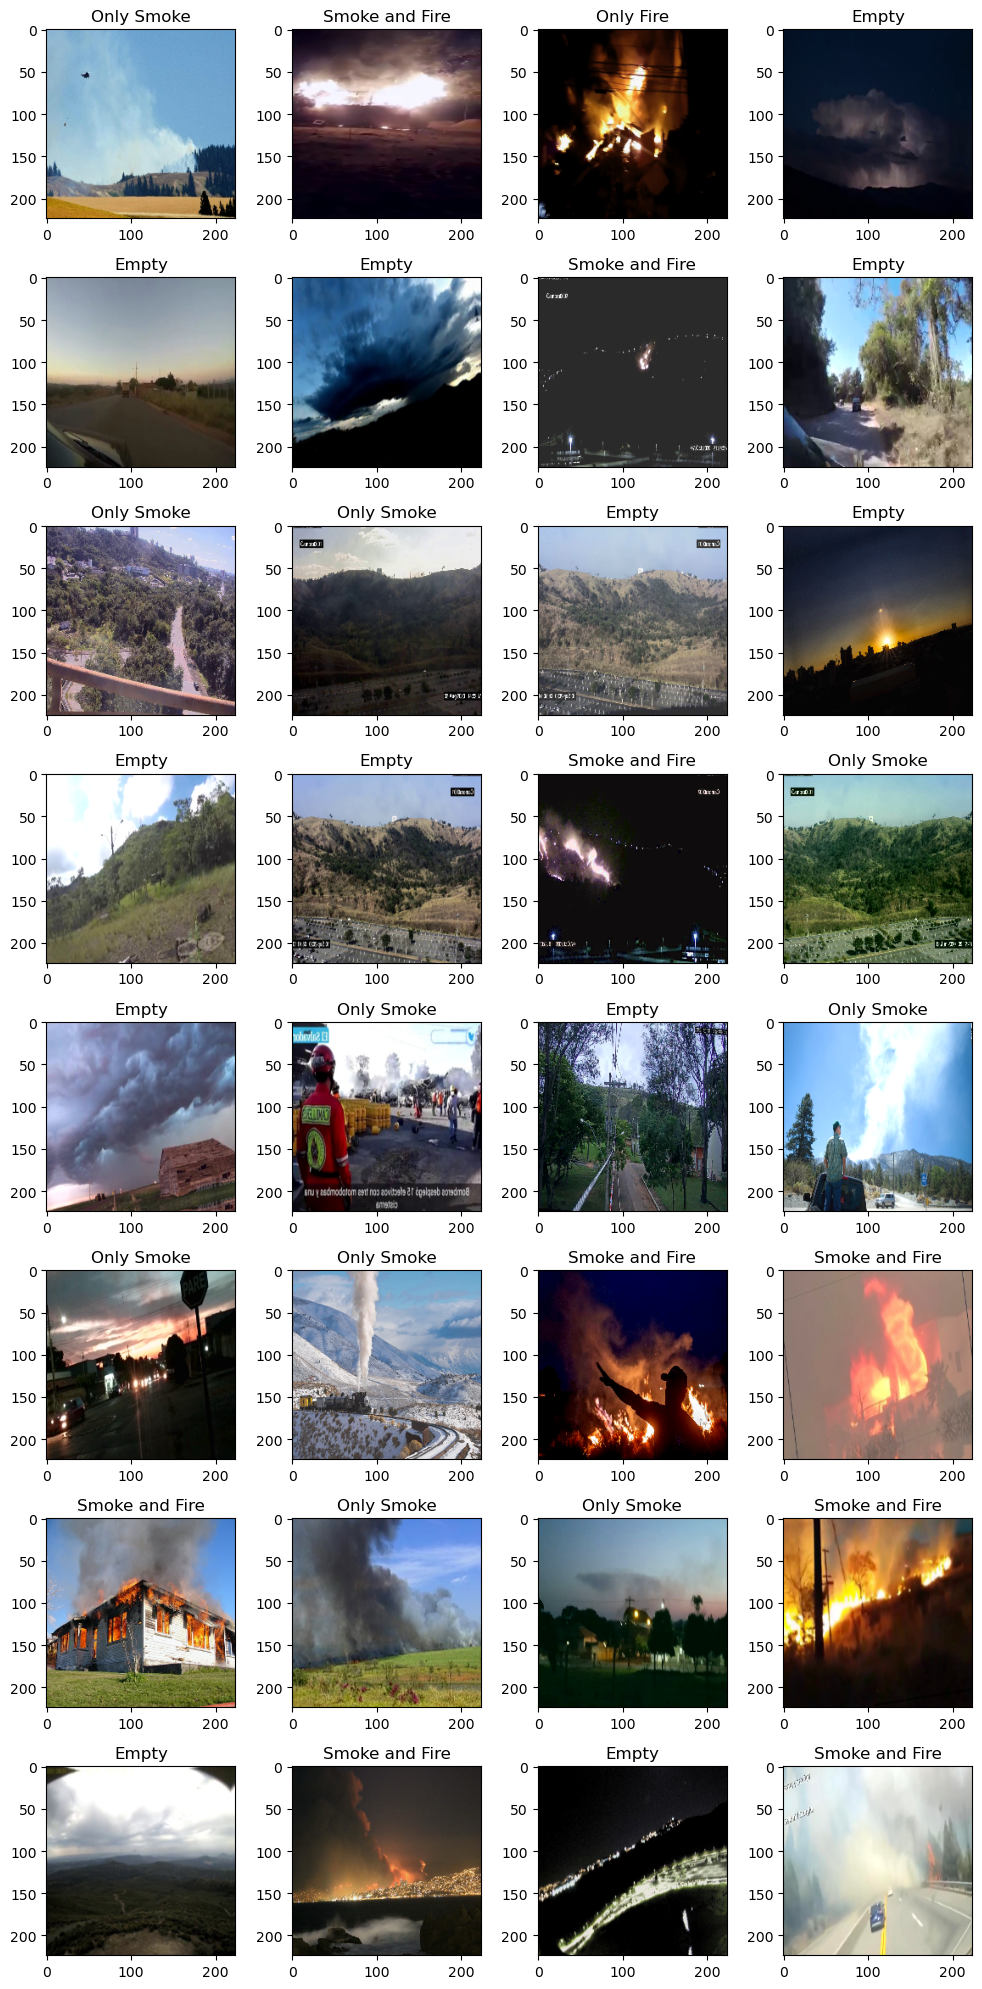

In [6]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Dataset Setup

In [7]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(config.IMG_H, config.IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.TRAIN_IMG_DIR,
    label_dir = config.TRAIN_LABEL_DIR,
    num_classes=config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(config.IMG_H, config.IMG_W, p=1),
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = dataset.DFireDataset(
    img_h = config.IMG_H,
    img_w = config.IMG_W,
    img_dir = config.VAL_IMG_DIR,
    label_dir = config.VAL_LABEL_DIR,
    num_classes = config.N_CLASSES,
    ds_len = config.DS_LEN,
    transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config.BATCH_SIZE,
                          num_workers=config.NUM_WORKERS,
                          pin_memory=config.PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config.BATCH_SIZE,
                        num_workers=config.NUM_WORKERS,
                        pin_memory=config.PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [8]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if config.MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = nn_model.BED_CLASSIFIER(num_classes=config.N_CLASSES).to(config.DEVICE)  
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, config.IMG_H, config.IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=config.DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=config.LEARNING_RATE, 
                       weight_decay=config.WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=config.FACTOR, 
                                                 patience=config.PATIENCE, 
                                                 threshold=config.THRES, 
                                                 threshold_mode='abs',
                                                 min_lr=config.MIN_LR)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[ 0.0010, -0.1684],
        [-0.1129, -0.2109],
        [ 0.0107, -0.1977],
        [ 0.0215, -0.2422]], device='cuda:0', grad_fn=<AddmmBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, mo

# Torchinfo: model summary

In [9]:
print(summary(model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))
logger.info(summary(model, input_size=(config.BATCH_SIZE, 3, config.IMG_H, config.IMG_W)))

Layer (type:depth-idx)                   Output Shape              Param #
BED_CLASSIFIER                           [64, 2]                   --
├─Sequential: 1-1                        [64, 2]                   --
│    └─Conv2d: 2-1                       [64, 32, 224, 224]        864
│    └─BatchNorm2d: 2-2                  [64, 32, 224, 224]        --
│    └─ReLU: 2-3                         [64, 32, 224, 224]        --
│    └─Dropout2d: 2-4                    [64, 32, 224, 224]        --
│    └─MaxPool2d: 2-5                    [64, 32, 112, 112]        --
│    └─Conv2d: 2-6                       [64, 16, 112, 112]        4,608
│    └─BatchNorm2d: 2-7                  [64, 16, 112, 112]        --
│    └─ReLU: 2-8                         [64, 16, 112, 112]        --
│    └─Dropout2d: 2-9                    [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-10                   [64, 16, 56, 56]          --
│    └─Conv2d: 2-11                      [64, 16, 56, 56]          256
│    └─Bat

# Print and Log Config Values

In [10]:
''' ============================
    Print Config Values
============================ '''
print(f'Device: {config.DEVICE}')
print(f'Learning Rate: {config.LEARNING_RATE}')
print(f'Weight Decay: {config.WEIGHT_DECAY}')
print(f'Batch Size: {config.BATCH_SIZE}')
print(f'IMG DIMS: ({config.IMG_H}, {config.IMG_W})')

logger.info(f'Device: {config.DEVICE}')
logger.info(f'Learning Rate: {config.LEARNING_RATE}')
logger.info(f'Weight Decay: {config.WEIGHT_DECAY}')
logger.info(f'Batch Size: {config.BATCH_SIZE}')
logger.info(f'W: {config.IMG_W}\nH: {config.IMG_H}')


# LOSS FUNCTION
if config.LOSS_FN == "BCE":
    print(f'Loss Function: BCE')
    logger.info(f'Loss Function: BCE')
    print(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    logger.info(f'Smoke Precision Weight: {config.SMOKE_PRECISION_WEIGHT}')
    loss_fn = loss.BCE_LOSS(device=config.DEVICE, smoke_precision_weight=config.SMOKE_PRECISION_WEIGHT)
else:
    print("Wrong loss function")
    logger.info("Wrong loss function")
    raise SystemExit("Wrong loss function")

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)
Loss Function: BCE
Smoke Precision Weight: 0.7


# Loss and Metrics Loggers and Plotters

In [11]:
train_losses_logger = utils.LogLosses()
train_metrics_logger = utils.LogMetrics()

val_losses_logger = utils.LogLosses()
val_metrics_logger = utils.LogMetrics()

loss_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Loss')
metrics_plotter = utils.PlotMetrics(log_path=config.PLOTS_FOLDER, model_name=config.MODEL, loss_or_metric='Metric')

# Main Function

In [12]:
def train_loop(model):

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = 0. #torch.tensor([0.])
    smoke_f1_min_save = 0.9 #torch.tensor([0.9])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0
    epochs_plot = []

    if config.LOAD_MODEL == False:
        if config.MODEL == "BED":
            model.__initialize_weights__()
            print("Initializing Weights")
            logger.info("Initializing Weights")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, config.EPOCHS):

        print(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{config.EPOCHS-1} ===')
        
        #====================== TRAINING ========================#
        logger.info(f'Learning Rate = {train_epoch.get_lr(optimizer=optimizer)}\n')
        
        train_losses, train_metrics = train_epoch.train_fn(
            loader=train_loader, 
            model=model, 
            optimizer=optimizer, 
            loss_fn=loss_fn,
            device=config.DEVICE)
        
        train_losses_logger.update_metrics(train_losses)
        train_metrics_logger.update_metrics(train_metrics)
                
        logger.info(utils.print_metrics_to_logger("TRAIN Stats", train_losses, train_metrics))
        
        #===================== VALIDATING =======================#
        with torch.no_grad():
            val_losses, val_metrics = val_epoch.eval_fn(
                loader=val_loader, 
                model=model,                         
                loss_fn=loss_fn,
                device=config.DEVICE)
            
            scheduler.step(val_losses['Total'])
            
            val_losses_logger.update_metrics(val_losses)
            val_metrics_logger.update_metrics(val_metrics)

            logger.info(utils.print_metrics_to_logger("VAL Stats", val_losses, val_metrics))
            
        epochs_plot.append(epoch)

        loss_plotter.plot_all_metrics(
            train_losses_logger.get_metrics(),
            val_losses_logger.get_metrics(),
            epochs_plot)

        metrics_plotter.plot_all_metrics(
            train_metrics_logger.get_metrics(),
            val_metrics_logger.get_metrics(),
            epochs_plot)

        #======================= SAVING =========================#
        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + config.MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_losses['Total']:
            best_valid_loss = val_losses['Total']
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_' + config.MODEL + '_classifier.pt') 

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < val_metrics['Precision'][0] ) and ( val_metrics['F1'][0] > smoke_f1_min_save ) :
            best_smoke_precision = val_metrics['Precision'][0]
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_' + config.MODEL + '_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_' + config.MODEL + '_classifier.pt') 
    
    #======================= FINISH =========================#
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [13]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model = train_loop(model=model)

Starting script


***Start Training: 18:50:40

Initializing Weights

=== EPOCH 0/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
67.152      |36.495      |30.658      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.822      |36.122      |24.699      
SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.750 - Recall: 0.444 - Accuracy: 0.818 - F1: 0.558

Saving model with new best validation loss: 60.822

=== EPOCH 1/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.107      |35.929      |26.177      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.211      |35.570      |22.641      
SMOKE -> Precision: 0.593 - Recall: 0.234 - Accuracy: 0.554 - F1: 0.336
FIRE -> Precision: 0.755 - Recall: 0.613 - Accuracy: 0.848 - F1: 0.676

Saving model with new best validation loss: 58.211

=== EPOCH 2/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.178      |35.517      |24.660      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.519      |35.205      |22.315      
SMOKE -> Precision: 0.642 - Recall: 0.260 - Accuracy: 0.574 - F1: 0.370
FIRE -> Precision: 0.773 - Recall: 0.605 - Accuracy: 0.852 - F1: 0.679

Saving model with new best validation loss: 57.519

=== EPOCH 3/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.828      |35.213      |23.615      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.887      |34.785      |21.102      
SMOKE -> Precision: 0.674 - Recall: 0.348 - Accuracy: 0.605 - F1: 0.459
FIRE -> Precision: 0.773 - Recall: 0.679 - Accuracy: 0.865 - F1: 0.723

Saving model with new best validation loss: 55.887

=== EPOCH 4/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.489      |34.870      |22.619      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.146      |34.072      |21.073      
SMOKE -> Precision: 0.697 - Recall: 0.439 - Accuracy: 0.638 - F1: 0.538
FIRE -> Precision: 0.731 - Recall: 0.755 - Accuracy: 0.865 - F1: 0.743

Saving model with new best validation loss: 55.146

=== EPOCH 5/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.361      |34.587      |21.773      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.640      |33.948      |18.692      
SMOKE -> Precision: 0.675 - Recall: 0.397 - Accuracy: 0.618 - F1: 0.500
FIRE -> Precision: 0.767 - Recall: 0.754 - Accuracy: 0.877 - F1: 0.761

Saving model with new best validation loss: 52.640

=== EPOCH 6/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.331      |34.342      |20.989      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.300      |33.775      |18.526      
SMOKE -> Precision: 0.701 - Recall: 0.433 - Accuracy: 0.638 - F1: 0.535
FIRE -> Precision: 0.800 - Recall: 0.729 - Accuracy: 0.883 - F1: 0.763

Saving model with new best validation loss: 52.300

=== EPOCH 7/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.193      |33.809      |20.383      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.984      |33.056      |16.927      
SMOKE -> Precision: 0.699 - Recall: 0.417 - Accuracy: 0.633 - F1: 0.523
FIRE -> Precision: 0.803 - Recall: 0.775 - Accuracy: 0.892 - F1: 0.789

Saving model with new best validation loss: 49.984

=== EPOCH 8/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.285      |33.589      |19.696      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.231      |32.440      |17.790      
SMOKE -> Precision: 0.720 - Recall: 0.520 - Accuracy: 0.672 - F1: 0.604
FIRE -> Precision: 0.765 - Recall: 0.846 - Accuracy: 0.893 - F1: 0.804

=== EPOCH 9/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.536      |33.377      |19.159      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.014      |31.938      |16.076      
SMOKE -> Precision: 0.725 - Recall: 0.441 - Accuracy: 0.651 - F1: 0.548
FIRE -> Precision: 0.850 - Recall: 0.775 - Accuracy: 0.906 - F1: 0.811

Saving model with new best validation loss: 48.014

=== EPOCH 10/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.086      |33.121      |18.965      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.645      |31.801      |15.844      
SMOKE -> Precision: 0.719 - Recall: 0.475 - Accuracy: 0.658 - F1: 0.572
FIRE -> Precision: 0.802 - Recall: 0.832 - Accuracy: 0.903 - F1: 0.816

Saving model with new best validation loss: 47.645

=== EPOCH 11/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.093      |32.752      |18.342      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.712      |31.690      |16.022      
SMOKE -> Precision: 0.735 - Recall: 0.416 - Accuracy: 0.647 - F1: 0.532
FIRE -> Precision: 0.861 - Recall: 0.740 - Accuracy: 0.902 - F1: 0.796

=== EPOCH 12/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.100      |32.441      |17.660      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.143      |30.819      |15.324      
SMOKE -> Precision: 0.738 - Recall: 0.520 - Accuracy: 0.681 - F1: 0.610
FIRE -> Precision: 0.802 - Recall: 0.850 - Accuracy: 0.907 - F1: 0.826

Saving model with new best validation loss: 46.143

=== EPOCH 13/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.817      |32.237      |17.581      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.576      |30.736      |15.840      
SMOKE -> Precision: 0.762 - Recall: 0.440 - Accuracy: 0.664 - F1: 0.558
FIRE -> Precision: 0.897 - Recall: 0.715 - Accuracy: 0.905 - F1: 0.796

=== EPOCH 14/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.398      |31.400      |16.999      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.320      |30.635      |16.685      
SMOKE -> Precision: 0.716 - Recall: 0.724 - Accuracy: 0.729 - F1: 0.720
FIRE -> Precision: 0.747 - Recall: 0.906 - Accuracy: 0.896 - F1: 0.819

=== EPOCH 15/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.555      |30.732      |16.823      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.142      |28.218      |13.924      
SMOKE -> Precision: 0.766 - Recall: 0.668 - Accuracy: 0.742 - F1: 0.713
FIRE -> Precision: 0.853 - Recall: 0.832 - Accuracy: 0.920 - F1: 0.843

Saving model with new best validation loss: 42.142

=== EPOCH 16/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.139      |29.886      |16.253      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.692      |26.587      |14.105      
SMOKE -> Precision: 0.812 - Recall: 0.647 - Accuracy: 0.758 - F1: 0.720
FIRE -> Precision: 0.822 - Recall: 0.880 - Accuracy: 0.920 - F1: 0.850

Saving model with new best validation loss: 40.692

=== EPOCH 17/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.760      |29.491      |16.269      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.962      |28.161      |13.802      
SMOKE -> Precision: 0.851 - Recall: 0.497 - Accuracy: 0.716 - F1: 0.627
FIRE -> Precision: 0.915 - Recall: 0.770 - Accuracy: 0.922 - F1: 0.837

=== EPOCH 18/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.830      |29.014      |15.816      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.061      |25.811      |14.250      
SMOKE -> Precision: 0.859 - Recall: 0.567 - Accuracy: 0.747 - F1: 0.683
FIRE -> Precision: 0.910 - Recall: 0.761 - Accuracy: 0.919 - F1: 0.829

Saving model with new best validation loss: 40.061

=== EPOCH 19/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.062      |28.507      |15.555      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.718      |24.747      |12.972      
SMOKE -> Precision: 0.865 - Recall: 0.575 - Accuracy: 0.753 - F1: 0.691
FIRE -> Precision: 0.855 - Recall: 0.841 - Accuracy: 0.922 - F1: 0.848

Saving model with new best validation loss: 37.718

=== EPOCH 20/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.810      |28.306      |15.504      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.963      |24.757      |12.207      
SMOKE -> Precision: 0.845 - Recall: 0.613 - Accuracy: 0.760 - F1: 0.711
FIRE -> Precision: 0.880 - Recall: 0.855 - Accuracy: 0.932 - F1: 0.867

Saving model with new best validation loss: 36.963

=== EPOCH 21/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.092      |27.899      |15.192      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.887      |24.798      |13.090      
SMOKE -> Precision: 0.849 - Recall: 0.577 - Accuracy: 0.747 - F1: 0.687
FIRE -> Precision: 0.909 - Recall: 0.784 - Accuracy: 0.924 - F1: 0.842

=== EPOCH 22/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.069      |27.295      |14.775      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.884      |23.722      |12.162      
SMOKE -> Precision: 0.804 - Recall: 0.775 - Accuracy: 0.801 - F1: 0.789
FIRE -> Precision: 0.911 - Recall: 0.812 - Accuracy: 0.931 - F1: 0.859

Saving model with new best validation loss: 35.884

=== EPOCH 23/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.295      |27.430      |14.864      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.351      |23.194      |12.157      
SMOKE -> Precision: 0.860 - Recall: 0.685 - Accuracy: 0.795 - F1: 0.763
FIRE -> Precision: 0.910 - Recall: 0.818 - Accuracy: 0.932 - F1: 0.861

Saving model with new best validation loss: 35.351

=== EPOCH 24/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.858      |27.203      |14.655      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.526      |23.630      |11.896      
SMOKE -> Precision: 0.855 - Recall: 0.627 - Accuracy: 0.769 - F1: 0.723
FIRE -> Precision: 0.918 - Recall: 0.814 - Accuracy: 0.933 - F1: 0.863

=== EPOCH 25/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.406      |26.636      |14.770      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.354      |23.383      |11.971      
SMOKE -> Precision: 0.858 - Recall: 0.636 - Accuracy: 0.774 - F1: 0.731
FIRE -> Precision: 0.835 - Recall: 0.897 - Accuracy: 0.927 - F1: 0.865

=== EPOCH 26/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.901      |26.409      |14.492      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.282      |23.710      |11.573      
SMOKE -> Precision: 0.885 - Recall: 0.623 - Accuracy: 0.780 - F1: 0.732
FIRE -> Precision: 0.913 - Recall: 0.818 - Accuracy: 0.933 - F1: 0.863

Saving model with new best validation loss: 35.282

=== EPOCH 27/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.567      |26.447      |14.121      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.031      |22.782      |12.249      
SMOKE -> Precision: 0.877 - Recall: 0.635 - Accuracy: 0.781 - F1: 0.736
FIRE -> Precision: 0.928 - Recall: 0.782 - Accuracy: 0.928 - F1: 0.849

Saving model with new best validation loss: 35.031

=== EPOCH 28/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.472      |26.230      |14.242      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.399      |21.329      |11.070      
SMOKE -> Precision: 0.853 - Recall: 0.769 - Accuracy: 0.825 - F1: 0.809
FIRE -> Precision: 0.893 - Recall: 0.862 - Accuracy: 0.938 - F1: 0.877

Saving model with new best validation loss: 32.399

=== EPOCH 29/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.110      |25.996      |14.115      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.596      |21.895      |11.701      
SMOKE -> Precision: 0.859 - Recall: 0.711 - Accuracy: 0.805 - F1: 0.778
FIRE -> Precision: 0.932 - Recall: 0.786 - Accuracy: 0.930 - F1: 0.853

=== EPOCH 30/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.500      |25.705      |13.795      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.284      |22.335      |10.949      
SMOKE -> Precision: 0.785 - Recall: 0.859 - Accuracy: 0.819 - F1: 0.820
FIRE -> Precision: 0.919 - Recall: 0.831 - Accuracy: 0.937 - F1: 0.873

=== EPOCH 31/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.091      |25.312      |13.779      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 26.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.205      |21.553      |10.652      
SMOKE -> Precision: 0.806 - Recall: 0.865 - Accuracy: 0.835 - F1: 0.835
FIRE -> Precision: 0.906 - Recall: 0.848 - Accuracy: 0.938 - F1: 0.876

Saving model with new best validation loss: 32.205

=== EPOCH 32/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.664      |25.096      |13.568      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.652      |22.084      |11.568      
SMOKE -> Precision: 0.799 - Recall: 0.856 - Accuracy: 0.827 - F1: 0.826
FIRE -> Precision: 0.917 - Recall: 0.821 - Accuracy: 0.934 - F1: 0.866

=== EPOCH 33/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.569      |24.945      |13.624      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.067      |21.304      |10.763      
SMOKE -> Precision: 0.834 - Recall: 0.793 - Accuracy: 0.824 - F1: 0.813
FIRE -> Precision: 0.884 - Recall: 0.880 - Accuracy: 0.939 - F1: 0.882

Saving model with new best validation loss: 32.067

=== EPOCH 34/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.289      |24.873      |13.416      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.496      |20.701      |10.795      
SMOKE -> Precision: 0.829 - Recall: 0.836 - Accuracy: 0.838 - F1: 0.832
FIRE -> Precision: 0.929 - Recall: 0.819 - Accuracy: 0.937 - F1: 0.871

Saving model with new best validation loss: 31.496

=== EPOCH 35/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.468      |24.901      |13.567      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.784      |20.886      |10.898      
SMOKE -> Precision: 0.861 - Recall: 0.730 - Accuracy: 0.813 - F1: 0.790
FIRE -> Precision: 0.868 - Recall: 0.877 - Accuracy: 0.934 - F1: 0.872

=== EPOCH 36/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:21<00:00, 12.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.221      |24.304      |12.917      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.366      |19.919      |10.447      
SMOKE -> Precision: 0.826 - Recall: 0.871 - Accuracy: 0.850 - F1: 0.848
FIRE -> Precision: 0.904 - Recall: 0.854 - Accuracy: 0.939 - F1: 0.878

Saving model with new best validation loss: 30.366

=== EPOCH 37/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.596      |24.260      |13.336      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.900      |20.464      |10.436      
SMOKE -> Precision: 0.882 - Recall: 0.714 - Accuracy: 0.816 - F1: 0.789
FIRE -> Precision: 0.915 - Recall: 0.834 - Accuracy: 0.937 - F1: 0.873

=== EPOCH 38/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.130      |24.137      |12.992      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.652      |20.522      |10.130      
SMOKE -> Precision: 0.862 - Recall: 0.789 - Accuracy: 0.838 - F1: 0.824
FIRE -> Precision: 0.890 - Recall: 0.889 - Accuracy: 0.943 - F1: 0.890

=== EPOCH 39/124 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.006      |24.030      |12.975      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.527      |22.372      |10.155      
SMOKE -> Precision: 0.921 - Recall: 0.618 - Accuracy: 0.791 - F1: 0.740
FIRE -> Precision: 0.874 - Recall: 0.895 - Accuracy: 0.939 - F1: 0.884

=== EPOCH 40/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.295      |23.678      |12.617      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.254      |20.647      |9.607       
SMOKE -> Precision: 0.894 - Recall: 0.703 - Accuracy: 0.817 - F1: 0.787
FIRE -> Precision: 0.899 - Recall: 0.878 - Accuracy: 0.943 - F1: 0.888

Saving model with new best validation loss: 30.254

=== EPOCH 41/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.133      |23.533      |12.600      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.477      |18.866      |10.610      
SMOKE -> Precision: 0.880 - Recall: 0.781 - Accuracy: 0.844 - F1: 0.828
FIRE -> Precision: 0.932 - Recall: 0.834 - Accuracy: 0.941 - F1: 0.880

Saving model with new best validation loss: 29.477

=== EPOCH 42/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.376      |23.531      |12.845      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.208      |19.375      |9.833       
SMOKE -> Precision: 0.832 - Recall: 0.888 - Accuracy: 0.860 - F1: 0.859
FIRE -> Precision: 0.877 - Recall: 0.902 - Accuracy: 0.942 - F1: 0.889

Saving model with new best validation loss: 29.208

=== EPOCH 43/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.452      |23.002      |12.450      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.226      |19.011      |12.215      
SMOKE -> Precision: 0.858 - Recall: 0.821 - Accuracy: 0.848 - F1: 0.839
FIRE -> Precision: 0.783 - Recall: 0.947 - Accuracy: 0.918 - F1: 0.857

=== EPOCH 44/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.310      |22.972      |12.337      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.491      |18.334      |9.158       
SMOKE -> Precision: 0.849 - Recall: 0.875 - Accuracy: 0.865 - F1: 0.862
FIRE -> Precision: 0.910 - Recall: 0.878 - Accuracy: 0.946 - F1: 0.894

Saving model with new best validation loss: 27.491

=== EPOCH 45/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.849      |22.615      |12.235      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.539      |18.710      |10.829      
SMOKE -> Precision: 0.884 - Recall: 0.775 - Accuracy: 0.843 - F1: 0.826
FIRE -> Precision: 0.829 - Recall: 0.937 - Accuracy: 0.934 - F1: 0.879

=== EPOCH 46/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.785      |22.549      |12.236      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.120      |18.762      |9.359       
SMOKE -> Precision: 0.836 - Recall: 0.877 - Accuracy: 0.858 - F1: 0.856
FIRE -> Precision: 0.902 - Recall: 0.911 - Accuracy: 0.951 - F1: 0.906

=== EPOCH 47/124 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.951      |22.659      |12.291      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.131      |18.669      |9.462       
SMOKE -> Precision: 0.896 - Recall: 0.744 - Accuracy: 0.835 - F1: 0.813
FIRE -> Precision: 0.936 - Recall: 0.849 - Accuracy: 0.946 - F1: 0.890

=== EPOCH 48/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.582      |22.364      |12.218      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.129      |17.463      |9.666       
SMOKE -> Precision: 0.889 - Recall: 0.794 - Accuracy: 0.854 - F1: 0.839
FIRE -> Precision: 0.864 - Recall: 0.930 - Accuracy: 0.944 - F1: 0.895

Saving model with new best validation loss: 27.129

=== EPOCH 49/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.872      |22.177      |11.694      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.490      |18.573      |9.917       
SMOKE -> Precision: 0.906 - Recall: 0.741 - Accuracy: 0.838 - F1: 0.815
FIRE -> Precision: 0.892 - Recall: 0.875 - Accuracy: 0.940 - F1: 0.884

=== EPOCH 50/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.569      |21.884      |11.686      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.125      |17.705      |9.420       
SMOKE -> Precision: 0.908 - Recall: 0.766 - Accuracy: 0.850 - F1: 0.831
FIRE -> Precision: 0.878 - Recall: 0.916 - Accuracy: 0.945 - F1: 0.897

Saving model with new best validation loss: 27.125

=== EPOCH 51/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.413      |21.698      |11.716      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.458      |17.164      |9.295       
SMOKE -> Precision: 0.894 - Recall: 0.799 - Accuracy: 0.858 - F1: 0.844
FIRE -> Precision: 0.939 - Recall: 0.848 - Accuracy: 0.946 - F1: 0.891

Saving model with new best validation loss: 26.458

=== EPOCH 52/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.274      |21.594      |11.680      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.597      |17.359      |11.238      
SMOKE -> Precision: 0.870 - Recall: 0.850 - Accuracy: 0.867 - F1: 0.860
FIRE -> Precision: 0.961 - Recall: 0.768 - Accuracy: 0.932 - F1: 0.854

=== EPOCH 53/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.101      |21.593      |11.508      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.108      |17.886      |9.223       
SMOKE -> Precision: 0.833 - Recall: 0.904 - Accuracy: 0.866 - F1: 0.867
FIRE -> Precision: 0.947 - Recall: 0.841 - Accuracy: 0.947 - F1: 0.891

=== EPOCH 54/124 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.105      |21.485      |11.620      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.090      |16.796      |10.294      
SMOKE -> Precision: 0.890 - Recall: 0.810 - Accuracy: 0.861 - F1: 0.849
FIRE -> Precision: 0.943 - Recall: 0.829 - Accuracy: 0.943 - F1: 0.882

=== EPOCH 55/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.136      |20.932      |11.205      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.958      |16.809      |9.149       
SMOKE -> Precision: 0.901 - Recall: 0.795 - Accuracy: 0.859 - F1: 0.844
FIRE -> Precision: 0.932 - Recall: 0.867 - Accuracy: 0.949 - F1: 0.898

Saving model with new best validation loss: 25.958

=== EPOCH 56/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.253      |20.925      |11.328      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.847      |15.868      |8.979       
SMOKE -> Precision: 0.886 - Recall: 0.857 - Accuracy: 0.878 - F1: 0.871
FIRE -> Precision: 0.885 - Recall: 0.919 - Accuracy: 0.948 - F1: 0.901

Saving model with new best validation loss: 24.847

=== EPOCH 57/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.816      |20.642      |11.174      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.693      |15.859      |8.834       
SMOKE -> Precision: 0.873 - Recall: 0.875 - Accuracy: 0.878 - F1: 0.874
FIRE -> Precision: 0.893 - Recall: 0.921 - Accuracy: 0.951 - F1: 0.906

Saving model with new best validation loss: 24.693

=== EPOCH 58/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.191      |21.028      |11.164      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.537      |16.376      |9.161       
SMOKE -> Precision: 0.887 - Recall: 0.827 - Accuracy: 0.866 - F1: 0.856
FIRE -> Precision: 0.934 - Recall: 0.861 - Accuracy: 0.948 - F1: 0.896

=== EPOCH 59/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.221      |20.851      |11.370      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.085      |16.189      |8.896       
SMOKE -> Precision: 0.899 - Recall: 0.826 - Accuracy: 0.872 - F1: 0.861
FIRE -> Precision: 0.935 - Recall: 0.868 - Accuracy: 0.950 - F1: 0.900

=== EPOCH 60/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.834      |20.659      |11.175      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.583      |16.930      |8.653       
SMOKE -> Precision: 0.900 - Recall: 0.801 - Accuracy: 0.861 - F1: 0.847
FIRE -> Precision: 0.925 - Recall: 0.877 - Accuracy: 0.950 - F1: 0.900

=== EPOCH 61/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.185      |20.079      |11.106      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.777      |16.858      |8.919       
SMOKE -> Precision: 0.917 - Recall: 0.771 - Accuracy: 0.856 - F1: 0.838
FIRE -> Precision: 0.942 - Recall: 0.860 - Accuracy: 0.950 - F1: 0.899

=== EPOCH 62/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.900      |20.159      |10.741      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.269      |15.933      |8.335       
SMOKE -> Precision: 0.900 - Recall: 0.833 - Accuracy: 0.875 - F1: 0.865
FIRE -> Precision: 0.917 - Recall: 0.896 - Accuracy: 0.952 - F1: 0.907

Saving model with new best validation loss: 24.269

=== EPOCH 63/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.557      |19.954      |10.603      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.267      |17.841      |8.426       
SMOKE -> Precision: 0.929 - Recall: 0.731 - Accuracy: 0.844 - F1: 0.818
FIRE -> Precision: 0.918 - Recall: 0.897 - Accuracy: 0.953 - F1: 0.908

=== EPOCH 64/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.898      |20.146      |10.751      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 25.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.389      |15.161      |9.228       
SMOKE -> Precision: 0.896 - Recall: 0.860 - Accuracy: 0.885 - F1: 0.878
FIRE -> Precision: 0.936 - Recall: 0.863 - Accuracy: 0.949 - F1: 0.898

=== EPOCH 65/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.186      |19.672      |10.513      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.790      |16.139      |10.651      
SMOKE -> Precision: 0.896 - Recall: 0.832 - Accuracy: 0.873 - F1: 0.863
FIRE -> Precision: 0.959 - Recall: 0.815 - Accuracy: 0.943 - F1: 0.881

=== EPOCH 66/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.228      |19.657      |10.571      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.968      |15.663      |8.305       
SMOKE -> Precision: 0.862 - Recall: 0.903 - Accuracy: 0.884 - F1: 0.882
FIRE -> Precision: 0.917 - Recall: 0.901 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 23.968

=== EPOCH 67/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.109      |19.558      |10.551      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.652      |14.817      |8.836       
SMOKE -> Precision: 0.880 - Recall: 0.899 - Accuracy: 0.892 - F1: 0.889
FIRE -> Precision: 0.960 - Recall: 0.859 - Accuracy: 0.954 - F1: 0.906

Saving model with new best validation loss: 23.652

=== EPOCH 68/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.707      |19.269      |10.438      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.965      |14.991      |7.974       
SMOKE -> Precision: 0.894 - Recall: 0.859 - Accuracy: 0.883 - F1: 0.876
FIRE -> Precision: 0.913 - Recall: 0.920 - Accuracy: 0.957 - F1: 0.917

Saving model with new best validation loss: 22.965

=== EPOCH 69/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.559      |19.269      |10.290      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.488      |15.422      |8.066       
SMOKE -> Precision: 0.908 - Recall: 0.812 - Accuracy: 0.870 - F1: 0.858
FIRE -> Precision: 0.906 - Recall: 0.908 - Accuracy: 0.952 - F1: 0.907

=== EPOCH 70/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.640      |19.243      |10.397      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.514      |15.320      |8.193       
SMOKE -> Precision: 0.898 - Recall: 0.845 - Accuracy: 0.879 - F1: 0.870
FIRE -> Precision: 0.918 - Recall: 0.903 - Accuracy: 0.954 - F1: 0.910

=== EPOCH 71/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.622      |19.211      |10.412      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.666      |15.473      |10.193      
SMOKE -> Precision: 0.928 - Recall: 0.801 - Accuracy: 0.874 - F1: 0.860
FIRE -> Precision: 0.962 - Recall: 0.815 - Accuracy: 0.944 - F1: 0.882

=== EPOCH 72/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.928      |18.849      |10.079      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.220      |15.223      |7.997       
SMOKE -> Precision: 0.866 - Recall: 0.914 - Accuracy: 0.891 - F1: 0.889
FIRE -> Precision: 0.930 - Recall: 0.898 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 73/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.940      |18.749      |10.192      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.915      |14.676      |8.239       
SMOKE -> Precision: 0.923 - Recall: 0.821 - Accuracy: 0.881 - F1: 0.869
FIRE -> Precision: 0.934 - Recall: 0.886 - Accuracy: 0.954 - F1: 0.909

Saving model with new best validation loss: 22.915

=== EPOCH 74/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.682      |18.935      |9.747       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.509      |14.610      |7.899       
SMOKE -> Precision: 0.890 - Recall: 0.879 - Accuracy: 0.890 - F1: 0.885
FIRE -> Precision: 0.917 - Recall: 0.914 - Accuracy: 0.956 - F1: 0.915

Saving model with new best validation loss: 22.509

=== EPOCH 75/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.372      |18.260      |10.112      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.303      |14.357      |7.946       
SMOKE -> Precision: 0.898 - Recall: 0.864 - Accuracy: 0.887 - F1: 0.881
FIRE -> Precision: 0.916 - Recall: 0.905 - Accuracy: 0.954 - F1: 0.911

Saving model with new best validation loss: 22.303

=== EPOCH 76/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.614      |18.472      |10.142      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.086      |15.013      |8.073       
SMOKE -> Precision: 0.888 - Recall: 0.868 - Accuracy: 0.884 - F1: 0.878
FIRE -> Precision: 0.923 - Recall: 0.904 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 77/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.797      |18.601      |10.196      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.384      |14.406      |7.978       
SMOKE -> Precision: 0.899 - Recall: 0.857 - Accuracy: 0.885 - F1: 0.878
FIRE -> Precision: 0.914 - Recall: 0.914 - Accuracy: 0.955 - F1: 0.914

=== EPOCH 78/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.711      |18.754      |9.957       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.591      |14.455      |8.136       
SMOKE -> Precision: 0.904 - Recall: 0.851 - Accuracy: 0.885 - F1: 0.877
FIRE -> Precision: 0.926 - Recall: 0.896 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 79/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.173      |18.168      |10.004      



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.774      |14.292      |8.482       
SMOKE -> Precision: 0.911 - Recall: 0.842 - Accuracy: 0.885 - F1: 0.876
FIRE -> Precision: 0.932 - Recall: 0.877 - Accuracy: 0.952 - F1: 0.904

=== EPOCH 80/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.762      |18.169      |9.593       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.305      |14.287      |8.018       
SMOKE -> Precision: 0.897 - Recall: 0.870 - Accuracy: 0.889 - F1: 0.883
FIRE -> Precision: 0.907 - Recall: 0.915 - Accuracy: 0.954 - F1: 0.911

=== EPOCH 81/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.744      |17.912      |9.831       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.842      |14.328      |8.514       
SMOKE -> Precision: 0.911 - Recall: 0.854 - Accuracy: 0.890 - F1: 0.882
FIRE -> Precision: 0.949 - Recall: 0.870 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 82/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.561      |17.995      |9.565       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.353      |13.980      |8.373       
SMOKE -> Precision: 0.923 - Recall: 0.845 - Accuracy: 0.891 - F1: 0.882
FIRE -> Precision: 0.949 - Recall: 0.877 - Accuracy: 0.956 - F1: 0.911

=== EPOCH 83/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.841      |18.111      |9.730       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.375      |13.652      |7.723       
SMOKE -> Precision: 0.910 - Recall: 0.872 - Accuracy: 0.897 - F1: 0.891
FIRE -> Precision: 0.923 - Recall: 0.905 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 21.375

=== EPOCH 84/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.494      |18.013      |9.482       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.362      |14.086      |8.277       
SMOKE -> Precision: 0.922 - Recall: 0.833 - Accuracy: 0.886 - F1: 0.875
FIRE -> Precision: 0.938 - Recall: 0.881 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 85/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.431      |17.834      |9.597       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.088      |13.698      |8.390       
SMOKE -> Precision: 0.918 - Recall: 0.860 - Accuracy: 0.896 - F1: 0.888
FIRE -> Precision: 0.883 - Recall: 0.925 - Accuracy: 0.949 - F1: 0.904

=== EPOCH 86/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.469      |17.980      |9.489       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.473      |15.513      |7.960       
SMOKE -> Precision: 0.940 - Recall: 0.773 - Accuracy: 0.867 - F1: 0.848
FIRE -> Precision: 0.938 - Recall: 0.890 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 87/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.982      |17.671      |9.310       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.398      |13.499      |7.899       
SMOKE -> Precision: 0.913 - Recall: 0.858 - Accuracy: 0.893 - F1: 0.885
FIRE -> Precision: 0.919 - Recall: 0.910 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 88/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.119      |17.576      |9.543       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.411      |13.614      |7.798       
SMOKE -> Precision: 0.893 - Recall: 0.899 - Accuracy: 0.900 - F1: 0.896
FIRE -> Precision: 0.933 - Recall: 0.892 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 89/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.833      |17.569      |9.264       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.054      |13.285      |7.769       
SMOKE -> Precision: 0.913 - Recall: 0.870 - Accuracy: 0.898 - F1: 0.891
FIRE -> Precision: 0.918 - Recall: 0.914 - Accuracy: 0.956 - F1: 0.916

Saving model with new best validation loss: 21.054

=== EPOCH 90/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.726      |17.294      |9.432       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.988      |13.325      |7.663       
SMOKE -> Precision: 0.906 - Recall: 0.887 - Accuracy: 0.901 - F1: 0.896
FIRE -> Precision: 0.931 - Recall: 0.902 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 20.988

=== EPOCH 91/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.627      |17.297      |9.331       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.185      |13.515      |7.670       
SMOKE -> Precision: 0.915 - Recall: 0.866 - Accuracy: 0.897 - F1: 0.890
FIRE -> Precision: 0.921 - Recall: 0.914 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 92/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.571      |17.359      |9.212       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.334      |13.355      |7.979       
SMOKE -> Precision: 0.896 - Recall: 0.902 - Accuracy: 0.902 - F1: 0.899
FIRE -> Precision: 0.948 - Recall: 0.888 - Accuracy: 0.958 - F1: 0.917

=== EPOCH 93/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.159      |17.677      |9.481       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.934      |13.166      |7.768       
SMOKE -> Precision: 0.916 - Recall: 0.867 - Accuracy: 0.898 - F1: 0.891
FIRE -> Precision: 0.930 - Recall: 0.896 - Accuracy: 0.956 - F1: 0.913

Saving model with new best validation loss: 20.934

=== EPOCH 94/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.567      |17.359      |9.208       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.299      |13.728      |7.571       
SMOKE -> Precision: 0.884 - Recall: 0.915 - Accuracy: 0.901 - F1: 0.899
FIRE -> Precision: 0.922 - Recall: 0.912 - Accuracy: 0.957 - F1: 0.917

=== EPOCH 95/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.961      |17.561      |9.400       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.312      |13.144      |8.168       
SMOKE -> Precision: 0.921 - Recall: 0.866 - Accuracy: 0.900 - F1: 0.893
FIRE -> Precision: 0.948 - Recall: 0.878 - Accuracy: 0.956 - F1: 0.912

=== EPOCH 96/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.658      |17.306      |9.353       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.221      |13.298      |7.923       
SMOKE -> Precision: 0.918 - Recall: 0.857 - Accuracy: 0.894 - F1: 0.886
FIRE -> Precision: 0.933 - Recall: 0.888 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 97/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.300      |17.263      |9.037       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.232      |13.378      |7.854       
SMOKE -> Precision: 0.902 - Recall: 0.885 - Accuracy: 0.899 - F1: 0.894
FIRE -> Precision: 0.940 - Recall: 0.896 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 98/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.583      |17.274      |9.309       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.969      |13.051      |7.918       
SMOKE -> Precision: 0.906 - Recall: 0.899 - Accuracy: 0.906 - F1: 0.902
FIRE -> Precision: 0.928 - Recall: 0.901 - Accuracy: 0.956 - F1: 0.914

Saving model with new best smoke precision: 0.906

=== EPOCH 99/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.766      |17.394      |9.372       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.909      |13.171      |7.738       
SMOKE -> Precision: 0.897 - Recall: 0.893 - Accuracy: 0.899 - F1: 0.895
FIRE -> Precision: 0.904 - Recall: 0.925 - Accuracy: 0.955 - F1: 0.915

Saving model with new best validation loss: 20.909

=== EPOCH 100/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.389      |17.137      |9.253       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.236      |13.408      |7.828       
SMOKE -> Precision: 0.919 - Recall: 0.858 - Accuracy: 0.895 - F1: 0.887
FIRE -> Precision: 0.933 - Recall: 0.899 - Accuracy: 0.957 - F1: 0.916

=== EPOCH 101/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.630      |17.270      |9.360       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 24.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.526      |12.898      |7.628       
SMOKE -> Precision: 0.913 - Recall: 0.873 - Accuracy: 0.899 - F1: 0.892
FIRE -> Precision: 0.934 - Recall: 0.904 - Accuracy: 0.958 - F1: 0.918

Saving model with new best validation loss: 20.526

=== EPOCH 102/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.513      |17.215      |9.298       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.836      |12.897      |7.939       
SMOKE -> Precision: 0.917 - Recall: 0.873 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.950 - Recall: 0.882 - Accuracy: 0.957 - F1: 0.915

=== EPOCH 103/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.958      |16.727      |9.232       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.744      |13.038      |7.706       
SMOKE -> Precision: 0.912 - Recall: 0.880 - Accuracy: 0.901 - F1: 0.896
FIRE -> Precision: 0.934 - Recall: 0.905 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 104/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.147      |16.925      |9.222       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.921      |13.118      |7.802       
SMOKE -> Precision: 0.912 - Recall: 0.871 - Accuracy: 0.897 - F1: 0.891
FIRE -> Precision: 0.923 - Recall: 0.906 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 105/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.287      |17.007      |9.280       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.196      |13.290      |7.906       
SMOKE -> Precision: 0.911 - Recall: 0.868 - Accuracy: 0.896 - F1: 0.889
FIRE -> Precision: 0.940 - Recall: 0.896 - Accuracy: 0.958 - F1: 0.917

=== EPOCH 106/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.213      |17.062      |9.151       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.581      |13.006      |7.575       
SMOKE -> Precision: 0.901 - Recall: 0.894 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.927 - Recall: 0.913 - Accuracy: 0.959 - F1: 0.920

=== EPOCH 107/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.201      |17.077      |9.124       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.631      |13.060      |7.571       
SMOKE -> Precision: 0.902 - Recall: 0.893 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.922 - Recall: 0.910 - Accuracy: 0.957 - F1: 0.916

=== EPOCH 108/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.035      |16.874      |9.161       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.554      |12.894      |7.661       
SMOKE -> Precision: 0.908 - Recall: 0.893 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.930 - Recall: 0.905 - Accuracy: 0.958 - F1: 0.917

Saving model with new best smoke precision: 0.908

=== EPOCH 109/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.235      |16.627      |8.608       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.640      |13.092      |7.548       
SMOKE -> Precision: 0.917 - Recall: 0.860 - Accuracy: 0.896 - F1: 0.888
FIRE -> Precision: 0.936 - Recall: 0.905 - Accuracy: 0.959 - F1: 0.920

=== EPOCH 110/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.392      |16.423      |8.969       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.453      |12.793      |7.660       
SMOKE -> Precision: 0.909 - Recall: 0.896 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.930 - Recall: 0.904 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 20.453

Saving model with new best smoke precision: 0.909

=== EPOCH 111/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.685      |16.888      |8.797       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.321      |12.768      |7.553       
SMOKE -> Precision: 0.905 - Recall: 0.895 - Accuracy: 0.904 - F1: 0.900
FIRE -> Precision: 0.932 - Recall: 0.901 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 20.321

=== EPOCH 112/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.584      |16.525      |9.059       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.680      |12.857      |7.824       
SMOKE -> Precision: 0.913 - Recall: 0.882 - Accuracy: 0.903 - F1: 0.897
FIRE -> Precision: 0.946 - Recall: 0.896 - Accuracy: 0.960 - F1: 0.920

=== EPOCH 113/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.936      |16.721      |9.215       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.584      |13.052      |7.532       
SMOKE -> Precision: 0.895 - Recall: 0.905 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.923 - Recall: 0.919 - Accuracy: 0.959 - F1: 0.921

=== EPOCH 114/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|███████████████████████████████| 269/269 [00:19<00:00, 13.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.697      |16.658      |9.039       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.585      |12.986      |7.599       
SMOKE -> Precision: 0.906 - Recall: 0.905 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.929 - Recall: 0.913 - Accuracy: 0.959 - F1: 0.920

=== EPOCH 115/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.154      |16.398      |8.757       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.325      |12.699      |7.625       
SMOKE -> Precision: 0.915 - Recall: 0.887 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.914 - Recall: 0.921 - Accuracy: 0.957 - F1: 0.917

Saving model with new best smoke precision: 0.915

=== EPOCH 116/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.526      |16.520      |9.006       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.687      |12.838      |7.849       
SMOKE -> Precision: 0.918 - Recall: 0.870 - Accuracy: 0.900 - F1: 0.893
FIRE -> Precision: 0.947 - Recall: 0.895 - Accuracy: 0.960 - F1: 0.920

=== EPOCH 117/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.391      |16.454      |8.937       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.590      |12.914      |7.677       
SMOKE -> Precision: 0.914 - Recall: 0.878 - Accuracy: 0.902 - F1: 0.896
FIRE -> Precision: 0.931 - Recall: 0.906 - Accuracy: 0.958 - F1: 0.919

=== EPOCH 118/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.169      |16.527      |8.641       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.670      |12.974      |7.696       
SMOKE -> Precision: 0.916 - Recall: 0.874 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.941 - Recall: 0.897 - Accuracy: 0.959 - F1: 0.918

=== EPOCH 119/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.441      |16.550      |8.891       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.393      |12.792      |7.601       
SMOKE -> Precision: 0.911 - Recall: 0.891 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.924 - Recall: 0.912 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 120/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.461      |16.600      |8.861       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.647      |13.006      |7.641       
SMOKE -> Precision: 0.916 - Recall: 0.870 - Accuracy: 0.899 - F1: 0.892
FIRE -> Precision: 0.929 - Recall: 0.910 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 121/124 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.516      |16.573      |8.942       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 22.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.442      |12.708      |7.734       
SMOKE -> Precision: 0.904 - Recall: 0.894 - Accuracy: 0.904 - F1: 0.899
FIRE -> Precision: 0.934 - Recall: 0.899 - Accuracy: 0.958 - F1: 0.916

=== EPOCH 122/124 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.015      |16.267      |8.748       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.615      |12.723      |7.891       
SMOKE -> Precision: 0.919 - Recall: 0.871 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.937 - Recall: 0.902 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 123/124 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.182      |16.316      |8.866       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.915      |13.085      |7.830       
SMOKE -> Precision: 0.921 - Recall: 0.854 - Accuracy: 0.894 - F1: 0.886
FIRE -> Precision: 0.932 - Recall: 0.898 - Accuracy: 0.957 - F1: 0.915

=== EPOCH 124/124 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|███████████████████████████████| 269/269 [00:20<00:00, 13.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.210      |16.429      |8.781       



Validating: 100%|███████████████████████████████| 67/67 [00:02<00:00, 23.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.504      |12.731      |7.773       
SMOKE -> Precision: 0.920 - Recall: 0.871 - Accuracy: 0.901 - F1: 0.895
FIRE -> Precision: 0.934 - Recall: 0.899 - Accuracy: 0.957 - F1: 0.916

***Script finished: 19:39:24

Time elapsed: 0:48:44.766140
